<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-Cost-Function-for-the-Logistic-Model" data-toc-modified-id="A-Cost-Function-for-the-Logistic-Model-1">A Cost Function for the Logistic Model</a></span></li><li><span><a href="#The-Cross-Entropy-Cost" data-toc-modified-id="The-Cross-Entropy-Cost-2">The Cross Entropy Cost</a></span></li><li><span><a href="#Gradient-of-the-Cross-Entropy-Cost" data-toc-modified-id="Gradient-of-the-Cross-Entropy-Cost-3">Gradient of the Cross Entropy Cost</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4">Summary</a></span></li></ul></div>

In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [4]:
# HIDDEN
lebron = pd.read_csv('lebron.csv')

## A Cost Function for the Logistic Model

We have defined a regression model for probabilities, the logistic model:

$$
\begin{aligned}
f_\hat{\theta} (x) = \sigma(\hat{\theta} \cdot x)
\end{aligned}
$$

Like the model for linear regression, this model has parameters $ \hat{\theta} $, a vector that contains one parameter for each feature of $ x $. We now address the problem of defining a cost function for this model which allows us to fit the model's parameters to data.

Intuitively, we want the model's predictions to match the data as closely as possible. Below we recreate a plot of LeBron's shot attempts in the 2017 NBA Playoffs using the distance of each shot from the basket. The points are jittered on the y-axis to mitigate overplotting.

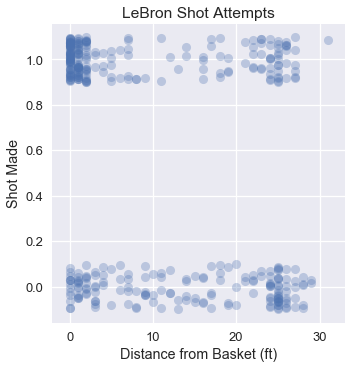

In [8]:
# HIDDEN
np.random.seed(42)
sns.lmplot(x='shot_distance', y='shot_made',
           data=lebron,
           fit_reg=False, ci=False,
           y_jitter=0.1,
           scatter_kws={'alpha': 0.3})
plt.title('LeBron Shot Attempts')
plt.xlabel('Distance from Basket (ft)')
plt.ylabel('Shot Made');

Noticing the large cluster of made shots close to the basket and the smaller cluster of missed shots further from the basket, we expect that a logistic model fitted on this data might look like:

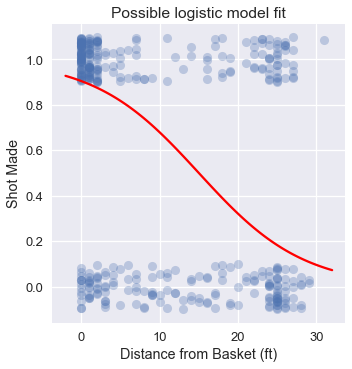

In [33]:
# HIDDEN
from scipy.special import expit

np.random.seed(42)
sns.lmplot(x='shot_distance', y='shot_made',
           data=lebron,
           fit_reg=False, ci=False,
           y_jitter=0.1,
           scatter_kws={'alpha': 0.3})

xs = np.linspace(-2, 32, 100)
ys = expit(-0.15 * (xs - 15))
plt.plot(xs, ys, c='r', label='Logistic model')

plt.title('Possible logistic model fit')
plt.xlabel('Distance from Basket (ft)')
plt.ylabel('Shot Made');

Although we can use the mean squared error cost function as we have for linear regression, for a logistic model this cost function is non-convex and thus difficult to optimize.

## The Cross Entropy Cost

Instead of the mean squared error, we use the **cross entropy cost**. Let $ X $ represent the $ n \times p $ input data matrix, $ y $ the vector of observed data values, and $ f_\hat{\theta}(x) $ the logistic model. Using this notation, the cross entropy cost is defined as:

$$
\begin{aligned}
L(\hat{\theta}, X, y) = \frac{1}{n} \sum_i \left(- y_i \ln (f_\hat{\theta}(X_i)) - (1 - y_i) \ln (1 - f_\hat{\theta}(X_i) \right)
\end{aligned}
$$

You may observe that as usual we take the mean loss over each point in our dataset. This loss is called the cross entropy loss and forms the inner expression in the above summation: 

$$
\begin{aligned}
\ell(\hat{\theta}, X, y) = - y_i \ln (f_\hat{\theta}(X_i)) - (1 - y_i) \ln (1 - f_\hat{\theta}(X_i) )
\end{aligned}
$$

Recall that each $ y_i $ is either 0 or 1 in our dataset. If $ y_i = 0 $, the first term in the loss is zero. If $ y_i = 1 $, the second term in the loss is zero. Thus, only one term of the cross entropy loss contributes to the overall cost for each point in our dataset.

Suppose $ y_i = 0 $ and our predicted probability $ f_\hat{\theta}(X_i) = 0 $—our model is completely correct. The loss for this point will be:

$$
\begin{aligned}
\ell(\hat{\theta}, X, y)
&= - y_i \ln (f_\hat{\theta}(X_i)) - (1 - y_i) \ln (1 - f_\hat{\theta}(X_i) ) \\
&= - 0 - (1 - 0) \ln (1 - 0 ) \\
&= - \ln (1) \\
&= 0
\end{aligned}
$$

As expected, the loss for a correct prediction is $ 0 $. You may verify that the further the predicted probability is from the true value, the greater the loss.

Minimizing the overall cross entropy cost requires the model $ f_\hat{\theta}(x) $ to make the most accurate predictions it can. Conveniently, this cost function is convex, making gradient descent a useful choice for optimization.

**Statistical justification for the cross entropy cost**

The cross entropy cost also has fundamental underpinnings in statistics. Since the logistic regression model predicts probabilities, given a particular logistic model we can ask, "What is the probability that this model produced the set of observed outcomes $ y $?" We might naturally adjust the parameters of our model until the probability of drawing our dataset from the model is as high as possible. Although we will not prove it in this section, this procedure is equivalent to minimizing the cross entropy cost—this is the *maximum likelihood* statistical justification for the cross entropy cost.

See the bottom of this section for another perspective on cross-entropy loss.

## Gradient of the Cross Entropy Cost

In order to run gradient descent on the cross entropy cost we must calculate the gradient of the cost function. First, we compute the derivative of the sigmoid function since we'll use it in our gradient calculation.

$$
\begin{aligned}
\sigma(t) &= \frac{1}{1 + e^{-t}} \\
\sigma'(t) &= \frac{e^{-t}}{(1 + e^{-t})^2} \\
\sigma'(t) &= \frac{1}{1 + e^{-t}} \cdot \left(1 - \frac{1}{1 + e^{-t}} \right) \\
\sigma'(t) &= \sigma(t) (1 - \sigma(t))
\end{aligned}
$$

The derivative of the sigmoid function can be conveniently expressed in terms of the sigmoid function itself.

As a shorthand, we define $ \sigma_i = f_\hat{\theta}(X_i) = \sigma(X_i \cdot \hat \theta) $. We will soon need the gradient of $ \sigma_i $ with respect to the vector $ \hat{\theta} $ so we will derive it now using a straightforward application of the chain rule. 

$$
\begin{aligned}
\nabla_{\hat{\theta}} \sigma_i
&= \nabla_{\hat{\theta}} \sigma(X_i \cdot \hat \theta) \\
&= \sigma(X_i \cdot \hat \theta) (1 - \sigma(X_i \cdot \hat \theta))  \nabla_{\hat{\theta}} (X_i \cdot \hat \theta) \\
&= \sigma_i (1 - \sigma_i) X_i 
\end{aligned}
$$

Now, we derive the gradient for the cross entropy cost with respect to the model parameters $ \hat{\theta} $. In the derivation below, we let $ \sigma_i = f_\hat{\theta}(X_i) = \sigma(X_i \cdot \hat \theta) $.

$$
\begin{aligned}
L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_i \left(- y_i \ln (f_\hat{\theta}(X_i)) - (1 - y_i) \ln (1 - f_\hat{\theta}(X_i) \right) \\
&= \frac{1}{n} \sum_i \left(- y_i \ln \sigma_i - (1 - y_i) \ln (1 - \sigma_i ) \right) \\
\nabla_{\hat{\theta}} L(\hat{\theta}, X, y)
&= \frac{1}{n} \sum_i \left(
    - \frac{y_i}{\sigma_i} \nabla_{\hat{\theta}} \sigma_i
    + \frac{1 - y_i}{1 - \sigma_i} \nabla_{\hat{\theta}} \sigma_i
\right) \\
&= - \frac{1}{n} \sum_i \left(
    \frac{y_i}{\sigma_i} - \frac{1 - y_i}{1 - \sigma_i}
\right) \nabla_{\hat{\theta}} \sigma_i \\
&= - \frac{1}{n} \sum_i \left(
    \frac{y_i}{\sigma_i} - \frac{1 - y_i}{1 - \sigma_i}
\right) \sigma_i (1 - \sigma_i) X_i \\
&= - \frac{1}{n} \sum_i \left(
    y_i - \sigma_i
\right) X_i \\
\end{aligned}
$$

The surprisingly simple gradient expression allows us to fit a logistic model to the cross entropy loss using gradient descent.

## Summary

The cross entropy cost that we use to fit the logistic model. Since it is a convex function, we use gradient descent to fit the model to the cost. We now have the necessary components of logistic regression: the model, cost function, and minimization procedure.

## KL Divergence and Cross-Entropy Cost

As noted at the beginning of the section, the goal is to closely approximate the real data distribution using a logistic model with parameters $\theta$:

$$ \hat{P_\theta}(y = 1 | x) \approx P(y = 1 | x) $$

**Kullback–Leibler (KL) divergence** provides a measure of the difference between two probability distributions. It reveals how much information is lost by using the model to approximate the real distribution. KL-divergence, also called relative entropy, has its roots in information theory (beyond the scope of DS 100).

The KL divergence between two distributions $P$ and $\hat{P_\theta}$ for a single data point $(x, y)$ is given by:

$$D(P || \hat{P}) = \sum_{k=0}^{K-1} P(y = k | x) \ln \left(\frac{P(y = k | x)}{\hat{P_\theta}(y = k | x)}\right)$$

$K$ represents the number of possible outcomes, so in the case of binary classification $K = 2$. 

The best $\theta$ minimizes the average KL divergence of the entire dataset of $n$ points:

$$\text{arg min}_{\theta} \frac{1}{n} \sum_{i=1}^{n} \sum_{k=0}^{K-1} P(y_i = k | x_i) \ln \left(\frac{P(y_i = k | x_i)}{\hat{P_\theta}(y_i = k | x_i)}\right)$$

Average KL divergence can be interpreted as the average log difference between the two distributions $P$ and $\hat{P_\theta}$ weighted by $P$. The structure of the equation has two important implications:

* KL divergence does not penalize mismatch for rare events with respect to $P$. If the model predicts a high probability for an event that is actually rare, then both $P(k)$ and $\ln \left(\frac{P(k)}{\hat{P}(k)}\right)$ are low so the divergence is also low. However, if the model predicts a low probability for an event that is actually common, then the divergence is high. 
* KL divergence is not symmetric: $$D(P || \hat{P}) \neq D(\hat{P} || P)$$

The logarithm of the ratio of probabilities hints back to the cross-entropy cost equation. In fact, minimizing average KL divergence is equivalent to minimizing average cross-entropy loss. The rest of this section walks through an algebraic derivation of cross-entropy cost from average KL divergence.

Using properties of logarithms, we can rewrite the weighted log ratio:
$$P(y_i = k | x_i) \ln \left(\frac{P(y_i = k | x_i)}{\hat{P_\theta}(y_i = k | x_i)}\right) = P(y_i = k | x_i) \ln P(y_i = k | x_i) - P(y_i = k | x_i) \ln \hat{P_\theta}(y_i = k | x_i)$$

Note that since the first term produced doesn't depend on $\theta$, it doesn't affect the arg min and can be removed from the equation. The resulting equation is the cross-entropy cost of the model $\hat{P_\theta}$:

$$\text{arg min}_{\theta} \frac{1}{n} \sum_{i=1}^{n} \sum_{k=0}^{K-1} -P(y_i = k | x_i) \ln \hat{P_\theta}(y_i = k | x_i)$$


We can now substitute equivalent terms to further simplify the equation to its more familiar form. Expanding the innermost summation over $K$ results in the following:

$$- P(y_i = 0 | x_i) \ln \hat{P_\theta}(y_i = 0 | x_i) + P(y_i = 1 | x_i) \ln \hat{P_\theta}(y_i = 1 | x_i)$$

Remembering that for our binary model, $y_i$ is the probability that $y_i = 1$, $P(y_i = 1 | x_i)$ is just $y_i$ and $P(y_i = 0 | x_i)$ is $1 - y_i$. The model's probability distribution $\hat{P_\theta}$ is given by the output of the sigmoid function from the beginning of the section. Putting this all together, we arrive at the cross-entropy cost equation.

$$ \text{arg min}_{\theta} \frac{1}{n} \sum_i \left(- y_i \ln (f_\hat{\theta}(X_i)) - (1 - y_i) \ln (1 - f_\hat{\theta}(X_i) \right) $$

